In [1]:
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

In [3]:
INPUT_FOLDER = "../input"
DATA = f"{INPUT_FOLDER}/accidents.csv"

In [4]:
def read_pickle(fname):
    with open(f"{INPUT_FOLDER}/{fname}.pickle", "rb") as f:
        return pickle.load(f)


In [5]:
accidents_only_roads_gdf = read_pickle("accidents_enriched_gdf")
pois_gdf = read_pickle("pois_gdf")
places_gdf = read_pickle("places_gdf")
ways_gdf = read_pickle("ways_gdf")
shape_gdf = read_pickle("shape_gdf")

In [6]:
def maybe(x, col, default=np.nan):
    try:
        return x[col]
    except:
        return default

In [7]:
one_meter = 0.00001

In [8]:
pois_gdf["geometry_circle=25m"] = pois_gdf["geometry"].buffer(one_meter * 25)
pois_gdf["geometry_circle=10m"] = pois_gdf["geometry"].buffer(one_meter * 10)

In [9]:
if "index_right" in pois_gdf.columns: del pois_gdf["index_right"]
if "index_right" in accidents_only_roads_gdf.columns: del accidents_only_roads_gdf["index_right"]

In [10]:
def pois_intersection_plot(title, pois_condition):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(title)
    (
        gpd.sjoin(
            accidents_only_roads_gdf,
            pois_gdf[pois_condition].set_geometry("geometry_circle=10m"),
            op="within"
        ).reset_index()
        .groupby("index")["index"].count()
    ).value_counts().plot(
        kind="bar", 
        title="10m",
        ax=axes[0]
    )

    (
        gpd.sjoin(
            accidents_only_roads_gdf,
            pois_gdf[pois_condition].set_geometry("geometry_circle=25m"),
            op="within"
        ).reset_index()
        .groupby("index")["index"].count()
    ).value_counts().plot(
        kind="bar", 
        title="25m",
        ax=axes[1]
    )
    
    return fig


####  Wypadki, a pasy dla pieszych.

Cóż, trudno tutaj jednoznacznie ocenić, jak oznaczone są przejścia dla pieszych. Trochę jest to zamieszane, trzeba podejrzeć to w overpass turbo. Narazie, traktowałbym to bardziej jako zabawę.

\[1\] https://wiki.openstreetmap.org/wiki/Key:crossing


<ipython-input-11-1932fe4b9acc>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pois_intersection_plot(


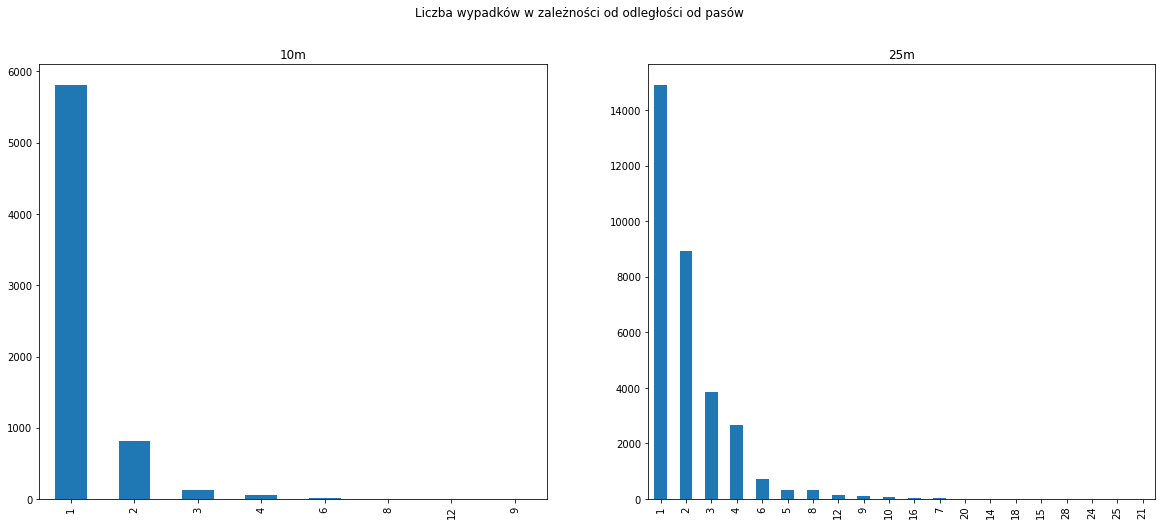

In [11]:
# https://wiki.openstreetmap.org/wiki/Key:crossing
pois_gdf["footway"] = pois_gdf["tags"].apply(lambda x: (maybe(x, "footway")))
pois_gdf["crossing"] = pois_gdf["tags"].apply(lambda x: (maybe(x, "crossing")))

pois_intersection_plot(
    "Liczba wypadków w zależności od odległości od pasów", 
     (pois_gdf["footway"] == "crossing") | (~pois_gdf["crossing"].isna())
).show()

####  Wypadki, a skrzyżowania.

Czy highway=crossing to przejście dla pieszych czy skrzyżowanie?

<ipython-input-12-6a865632a307>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pois_intersection_plot(


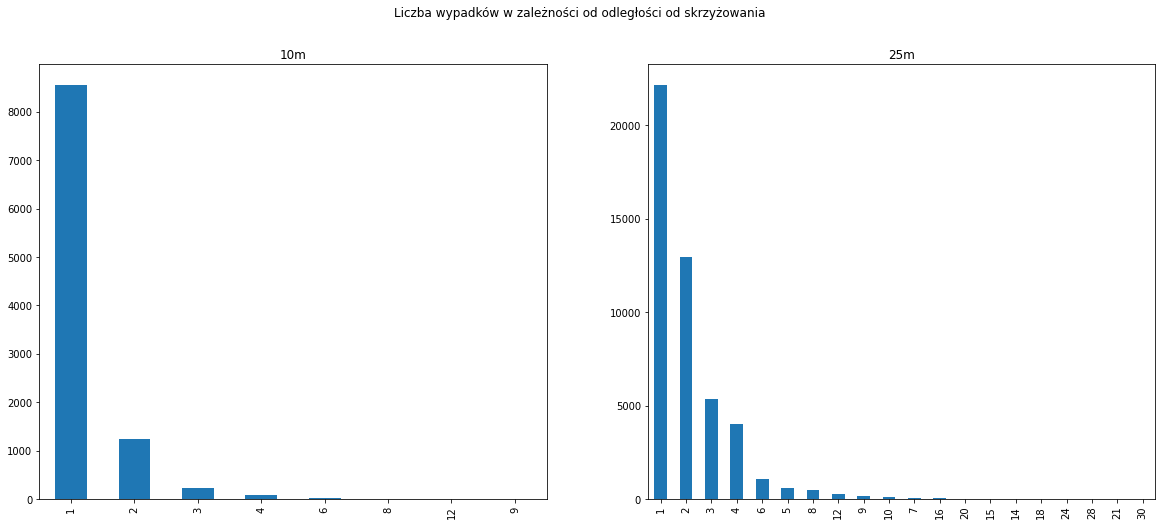

In [12]:
pois_gdf["highway"] = pois_gdf["tags"].apply(lambda x: (maybe(x, "highway")))

pois_intersection_plot(
    "Liczba wypadków w zależności od odległości od skrzyżowania", 
     (pois_gdf["highway"] == "crossing")
).show()

#### Wypadki, a rondo.

Coś mało tych rond, trzeba podejrzeć:

- czy problem jest z wyciągnietymi danymi
- czy może jednak są tak słabo te ronda oznaczone
- czy może jednak są oznaczone inaczej niż mi się wydaje

\[1\] https://wiki.openstreetmap.org/wiki/Tag:junction%3Droundabout

<ipython-input-13-268a9bb824bd>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pois_intersection_plot(


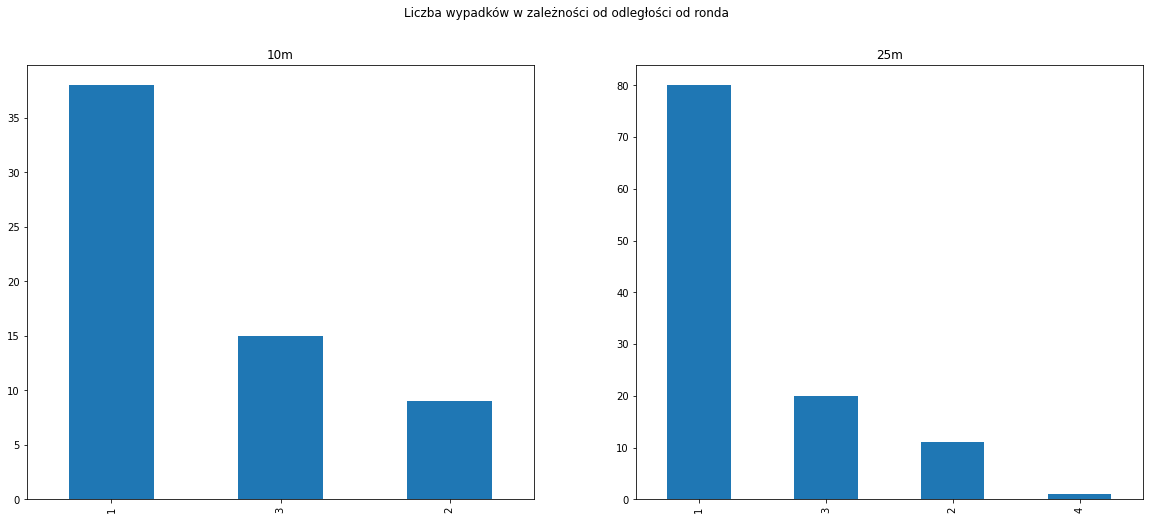

In [13]:
pois_gdf["junction"] = pois_gdf["tags"].apply(lambda x: (maybe(x, "junction")))

pois_intersection_plot(
    "Liczba wypadków w zależności od odległości od ronda", 
     ((pois_gdf["junction"] == "yes") | (pois_gdf["junction"] == "roundabout"))
).show()

#### Wypadki, a światła.

<ipython-input-14-5b54e2046360>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pois_intersection_plot(


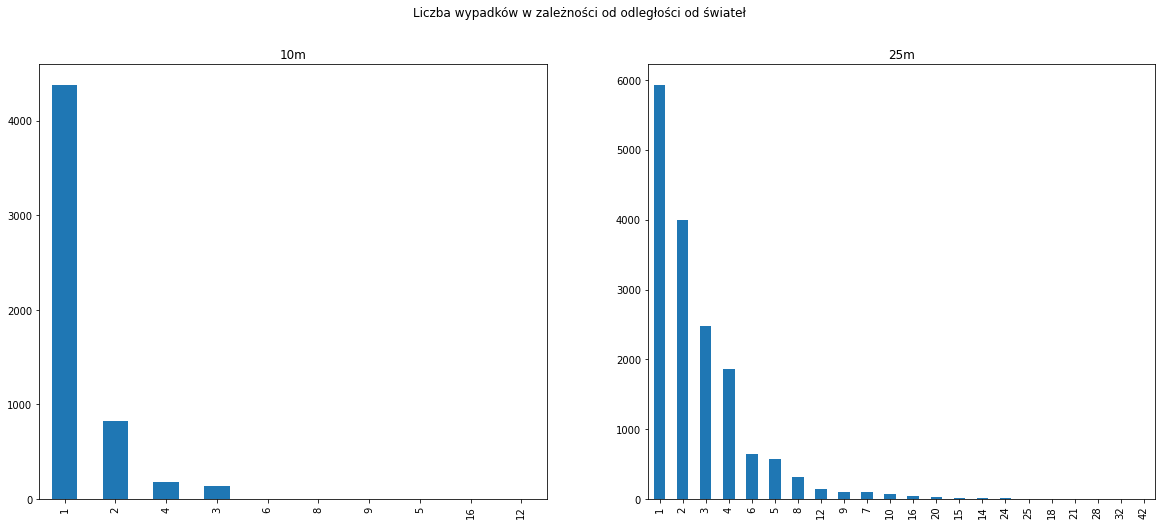

In [14]:
pois_gdf["crossing"] = pois_gdf["tags"].apply(lambda x: (maybe(x, "crossing")))

pois_intersection_plot(
    "Liczba wypadków w zależności od odległości od świateł", 
     ((pois_gdf["highway"] == "traffic_signals") | (pois_gdf["crossing"] == "traffic_signals"))
    
).show()

#### Wypadek, a dozwolona prędkość.

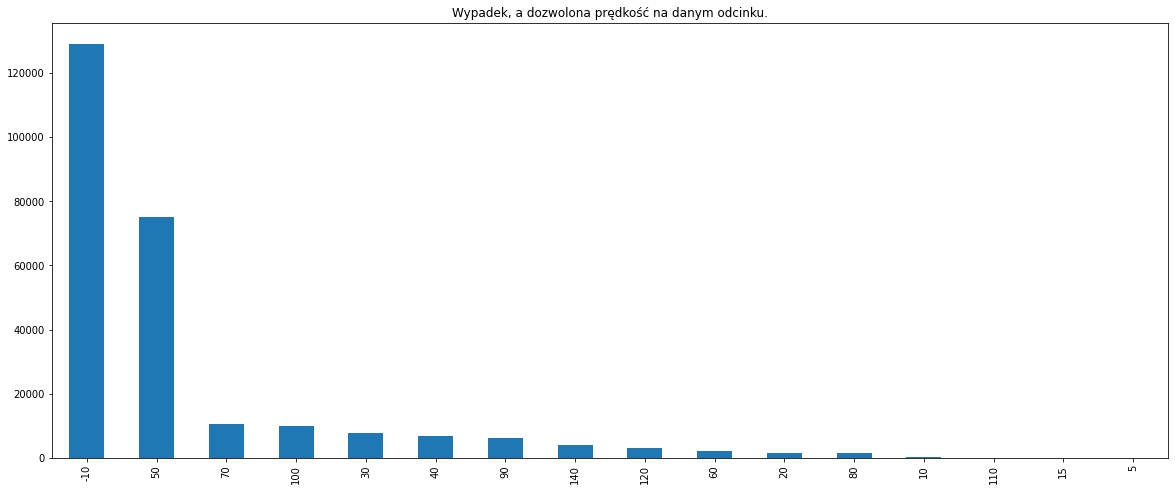

In [15]:
accidents_only_roads_gdf["max_speed"] = accidents_only_roads_gdf["tags"].apply(
    lambda x: (maybe(x, "maxspeed", -10))
)
(
    accidents_only_roads_gdf["max_speed"].value_counts()
        .plot(kind="bar", title="Wypadek, a dozwolona prędkość na danym odcinku.")
)